## Тест модуля восстановления глубины

#### Импортирование общих библиотек и OPR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/docker_opr/OpenPlaceRecognition/src')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from cv2 import imread
from skimage.transform import resize
from scipy.spatial.transform import Rotation

In [4]:
import sys
sys.path.append('/home/docker_opr/OpenPlaceRecognition/third_party/Depth-Anything-V2/')  # локальный путь до кода

import cv2
import torch
import os
import pandas as pd
import numpy as np
import random
import os
import gc
import time
import open3d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import transformers
import cv2.aruco as aruco
import torch.nn.functional as F

from copy import deepcopy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from accelerate import DistributedDataParallelKwargs, Accelerator, notebook_launcher
from accelerate.utils import set_seed
from tqdm import tqdm
from PIL import Image
from depth_anything_v2.dpt import DepthAnythingV2
from metric_depth.depth_anything_v2.dpt import DepthAnythingV2 as DepthAnythingV2Metric
from metric_depth.dataset.transform import Resize, NormalizeImage, PrepareForNet, Crop
from metric_depth.util.loss import SiLogLoss

xFormers not available
xFormers not available
xFormers not available
xFormers not available


In [5]:
from opr.pipelines.depth_estimation import DepthEstimationPipeline

#### Задание нейросети восстановления глубины

Загрузка чекпоинтов:

In [6]:
!mkdir -p /home/docker_opr/OpenPlaceRecognition/third_party/AdelaiDepth/weights/
!wget -O /home/docker_opr/OpenPlaceRecognition/third_party/AdelaiDepth/weights/res50.pth https://huggingface.co/ffranchina/LeReS/resolve/main/res50.pth

--2025-05-06 10:24:31--  https://huggingface.co/ffranchina/LeReS/resolve/main/res50.pth
Resolving huggingface.co (huggingface.co)... 18.165.121.59, 18.165.121.17, 18.165.121.117, ...
Connecting to huggingface.co (huggingface.co)|18.165.121.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/fe/30/fe30e2a7e2c5442183543060c71dada66c231bde6903ea26fcad1aa0a905a54a/fd2cb87a4369d5c230a01a81ce8cd359b3f5f0f997341a7dc815217ba6a66970?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27res50.pth%3B+filename%3D%22res50.pth%22%3B&Expires=1746530671&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjUzMDY3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2ZlLzMwL2ZlMzBlMmE3ZTJjNTQ0MjE4MzU0MzA2MGM3MWRhZGE2NmMyMzFiZGU2OTAzZWEyNmZjYWQxYWEwYTkwNWE1NGEvZmQyY2I4N2E0MzY5ZDVjMjMwYTAxYTgxY2U4Y2QzNTliM2Y1ZjBmOTk3MzQxYTdkYzgxNTIxN2JhNmE2Njk3MD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPS

In [7]:
sys.path.append('/home/docker_opr/OpenPlaceRecognition/third_party/AdelaiDepth/LeReS/Minist_Test')
from lib.multi_depth_model_woauxi import RelDepthModel
from lib.net_tools import load_ckpt

def parse_args(a):
    parser = argparse.ArgumentParser(
        description='Configs for LeReS')
    parser.add_argument('--load_ckpt', default='./res50.pth', help='Checkpoint path to load')
    parser.add_argument('--backbone', default='resnext101', help='Checkpoint path to load')

    args = parser.parse_args(a)
    return args

import argparse
arguments = "--load_ckpt /home/docker_opr/OpenPlaceRecognition/third_party/AdelaiDepth/weights/res50.pth \
            --backbone resnet50".split()
args = parse_args(arguments)

old_model = RelDepthModel(backbone='resnet50').cuda()
load_ckpt(args, old_model, None, None)

loading checkpoint /home/docker_opr/OpenPlaceRecognition/third_party/AdelaiDepth/weights/res50.pth


#### Dataset download

You can download the dataset:

- Kaggle:
  - [ITLP Campus Indoor](https://www.kaggle.com/datasets/alexandermelekhin/itlp-campus-indoor)
  - [ITLP Campus Outdoor](https://www.kaggle.com/datasets/alexandermelekhin/itlp-campus-outdoor)
- Hugging Face:
  - [ITLP Campus Indoor](https://huggingface.co/datasets/OPR-Project/ITLP-Campus-Indoor)
  - [ITLP Campus Outdoor](https://huggingface.co/datasets/OPR-Project/ITLP-Campus-Outdoor)


In [8]:
MODELS_BASE_PATH = '/home/docker_opr/OpenPlaceRecognition/third_party/Depth-Anything-V2/weights'
#DATA_BASE_PATH = '/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_5'
DATA_BASE_PATH = '/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/03_2023-04-11/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
from typing import Tuple

def project_points_to_camera(
    points: np.ndarray, proj_matrix: np.ndarray, cam_res: Tuple[int, int]
) -> Tuple[np.ndarray, np.ndarray]:
    if points.shape[0] == 3:
        points = np.vstack((points, np.ones((1, points.shape[1]))))
    if len(points.shape) != 2 or points.shape[0] != 4:
        raise ValueError(
            f"Wrong shape of points array: {points.shape}; expected: (4, n), where n - number of points."
        )
    if proj_matrix.shape != (3, 4):
        raise ValueError(f"Wrong proj_matrix shape: {proj_matrix}; expected: (3, 4).")
    in_image = points[2, :] > 0
    depths = points[2, in_image]
    uvw = np.dot(proj_matrix, points[:, in_image])
    uv = uvw[:2, :]
    w = uvw[2, :]
    uv[0, :] /= w
    uv[1, :] /= w
    in_image = (uv[0, :] >= 0) * (uv[0, :] < cam_res[0]) * (uv[1, :] >= 0) * (uv[1, :] < cam_res[1])
    return uv[:, in_image].astype(int), depths[in_image]

In [10]:
model_configs = {
    'small': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'base': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'large': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

загрузка чекпоинта для Depth Anything:

In [11]:
!mkdir -p /home/docker_opr/OpenPlaceRecognition/third_party/Depth-Anything-V2/weights
!wget -O /home/docker_opr/OpenPlaceRecognition/third_party/Depth-Anything-V2/weights/depth_anything_v2_metric_vkitti_vits.pth https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Small/resolve/main/depth_anything_v2_metric_vkitti_vits.pth

--2025-05-06 10:25:28--  https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Small/resolve/main/depth_anything_v2_metric_vkitti_vits.pth
Resolving huggingface.co (huggingface.co)... 18.165.121.80, 18.165.121.117, 18.165.121.17, ...
Connecting to huggingface.co (huggingface.co)|18.165.121.80|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/ff/9e/ff9ec3ee8db5ab81663fa79a7ae561bc8ee53042d8e48c4fcd8e7942fba39e9c/9203e538d35255c90dda4b7fedb47ff33fe725497bcca3b1e53b3a65ee63f0cb?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27depth_anything_v2_metric_vkitti_vits.pth%3B+filename%3D%22depth_anything_v2_metric_vkitti_vits.pth%22%3B&Expires=1746530728&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjUzMDcyOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2ZmLzllL2ZmOWVjM2VlOGRiNWFiODE2NjNmYTc5YTdhZTU2MWJjOGVlNTMwNDJkOGU0OGM0ZmNkOGU3OTQyZmJhMzllO

In [12]:
type = 'small'
params = model_configs[type]
new_model = DepthAnythingV2Metric(**params, max_depth=20)
model_path=os.path.join(MODELS_BASE_PATH, 'depth_anything_v2_metric_vkitti_vits.pth')
#model_path=os.path.join(MODELS_BASE_PATH, 'depth_anything_v2_vits.pth')
new_model.load_state_dict(torch.load(model_path))
new_model.to(DEVICE)

INFO:dinov2:using MLP layer as FFN


DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

#### Задание трансформации между лидаром и камерой (данные из росбэга с робота Husky)

In [13]:
fx = 683.6
fy = fx
cx = 615.1
cy = 345.3
camera_matrix = {'f': fx, 'cx': cx, 'cy': cy}
proj_matrix = np.array([
    [fx, 0.0, cx, 0],
    [0.0, fy, cy, 0],
    [0.0, 0.0, 1.0, 0]
])
rotation = [-0.498, 0.498, -0.495, 0.510]
R = Rotation.from_quat(rotation).as_matrix()
#R = np.linalg.inv(R)
translation = np.array([[0.061], [0.049], [-0.131]])
tf_matrix = np.concatenate([R, translation], axis=1)
tf_matrix = np.concatenate([tf_matrix, np.array([[0, 0, 0, 1]])], axis=0)

In [14]:
tf_matrix.T

array([[ 0.01505794, -0.99977525, -0.01492309,  0.        ],
       [ 0.00888194,  0.01505794, -0.99984717,  0.        ],
       [ 0.99984717,  0.01492309,  0.00910668,  0.        ],
       [ 0.061     ,  0.049     , -0.131     ,  1.        ]])

#### Инициализация модуля восстановления глубины

In [15]:
de_old = DepthEstimationPipeline(old_model, model_type='AdelaiDepth', align_type='average', mode='outdoor')
de_old.set_camera_matrix(camera_matrix)
de_old.set_lidar_to_camera_transform(tf_matrix)

In [16]:
de_new = DepthEstimationPipeline(new_model, model_type='DepthAnything', align_type='average', mode='outdoor')
de_new.set_camera_matrix(camera_matrix)
de_new.set_lidar_to_camera_transform(tf_matrix)

#### Запуск восстановления глубины

In [17]:
rmses_old = []
rels_old = []
rmses_new = []
rels_new = []

In [18]:
import pandas as pd
from tqdm import tqdm_notebook
zs_all = {}
rel_errors_all = {}
errors_all = {}

In [19]:
for track_dir in ['01_2023-02-21', '03_2023-04-11']:
    DATA_BASE_PATH = '/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/{}'.format(track_dir)
    track_csv = pd.read_csv(os.path.join(DATA_BASE_PATH, 'track.csv'))
    track_csv['front_cam_ts'] = track_csv['front_cam_ts'].astype(str)
    track_csv['lidar_ts'] = track_csv['lidar_ts'].astype(str)
    zs_all[track_dir] = []
    rel_errors_all[track_dir] = []
    errors_all[track_dir] = []
    for i in tqdm_notebook(range(track_csv.shape[0])):
        ts_cam = track_csv['front_cam_ts'].iloc[i]
        ts_lidar = track_csv['lidar_ts'].iloc[i]
        # print(ts_cam, ts_lidar)
        test_img_file = os.path.join(DATA_BASE_PATH, 'front_cam', '{}.png'.format(ts_cam))
        test_cloud_file = os.path.join(DATA_BASE_PATH, 'lidar', '{}.bin'.format(ts_lidar))
        test_img = imread(test_img_file)
        test_img = test_img[:, :, :3]
        test_cloud = np.fromfile(test_cloud_file, dtype=np.float32).reshape((-1, 4))[:, :-1]
        test_cloud = test_cloud[test_cloud == test_cloud].reshape((-1, 3))
        # print(test_img.shape)
        # print(test_cloud.shape)
        # print(test_cloud.min(), test_cloud.max())
        depth, zs, errors, rel_errors = de_old.get_depth_with_lidar(test_img, test_cloud[:, :3])
        rmse = np.sqrt(np.mean(errors ** 2))
        rel = np.mean(rel_errors)
        # print(rmse, rel)
        rmses_old.append(rmse)
        rels_old.append(rel)
        depth, zs, errors, rel_errors = de_new.get_depth_with_lidar(test_img, test_cloud[:, :3])
        rmse = np.sqrt(np.mean(errors ** 2))
        rel = np.mean(rel_errors)
        # print(rmse, rel)
        rmses_new.append(rmse)
        rels_new.append(rel)
        zs_all[track_dir] += list(zs)
        rel_errors_all[track_dir] += list(rel_errors)
        errors_all[track_dir] += list(errors)

/tmp/ipykernel_6636/686864317.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(track_csv.shape[0])):


  0%|          | 0/620 [00:00<?, ?it/s]

/tmp/ipykernel_6636/686864317.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(track_csv.shape[0])):


  0%|          | 0/638 [00:00<?, ?it/s]

In [20]:
def get_cloud_by_timestamp(data_dir, ts, float32=False):
    stamps = [int(x[:-4]) for x in os.listdir(os.path.join(data_dir, 'lidar'))]
    stamps.sort()
    i = 0
    #if float32:
    #    stamps = np.array(stamps) * 1000
    while i < len(stamps) and stamps[i] < ts:
        i += 1
    #print(i, len(stamps))
    if i == len(stamps):
        stamp = stamps[-1]
    elif i == 0:
        stamp = stamps[0]
    elif ts - stamps[i - 1] < stamps[i] - ts:
        stamp = stamps[i - 1]
    else:
        stamp = stamps[i]
    #print(ts, stamp, ts - stamp)
    if float32:
        return stamp, np.fromfile(os.path.join('dataset', data_dir, 'lidar', '{}.bin'.format(stamp)), 
                           dtype=np.float32).reshape((-1, 4))[:, :-1]
    return stamp, np.fromfile(os.path.join('dataset', data_dir, 'lidar', '{}.bin'.format(stamp))).reshape((-1, 3))

In [21]:
def get_image_by_timestamp(data_dir, ts):
    stamps = [int(x[:-4]) for x in os.listdir(os.path.join(data_dir, 'front_cam'))]
    stamps.sort()
    i = 0
    #if float32:
    #    stamps = np.array(stamps) * 1000
    while i < len(stamps) and stamps[i] < ts:
        i += 1
    #print(i, len(stamps))
    if i == len(stamps):
        stamp = stamps[-1]
    elif i == 0:
        stamp = stamps[0]
    elif ts - stamps[i - 1] < stamps[i] - ts:
        stamp = stamps[i - 1]
    else:
        stamp = stamps[i]
    # print(ts, stamp, ts - stamp)
    return stamp, imread(os.path.join(data_dir, 'front_cam', '{}.png'.format(stamp)))

In [22]:
for track_dir in ['05_2023-08-15-day', '07_2023-10-04-day']:
    DATA_BASE_PATH = '/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/{}'.format(track_dir)
    track_csv = pd.read_csv(os.path.join(DATA_BASE_PATH, 'track.csv'))
    # print(track_csv.shape, track_csv.columns)
    track_csv['timestamp'] = track_csv['timestamp'].astype(int)
    # print(track_csv['timestamp'].values)
    zs_all[track_dir] = []
    rel_errors_all[track_dir] = []
    errors_all[track_dir] = []
    for i in tqdm_notebook(range(0, track_csv.shape[0], 10)):
        stamp = track_csv.iloc[i]['timestamp']
        ts_lidar, test_cloud = get_cloud_by_timestamp(DATA_BASE_PATH, stamp, float32=False)
        ts_cam, test_img = get_image_by_timestamp(DATA_BASE_PATH, stamp)
        test_img = test_img[:, :, :3]
        test_cloud = test_cloud[(test_cloud == test_cloud).all(axis=1)]
        # print(test_img.shape)
        # print(test_cloud.shape)
        # print(test_cloud.min(), test_cloud.max())
        depth, zs, errors, rel_errors = de_old.get_depth_with_lidar(test_img, test_cloud[:, :3])
        rmse = np.sqrt(np.mean(errors ** 2))
        rel = np.mean(rel_errors)
        rmses_old.append(rmse)
        rels_old.append(rel)
        depth, zs, errors, rel_errors = de_new.get_depth_with_lidar(test_img, test_cloud[:, :3])
        rmse = np.sqrt(np.mean(errors ** 2))
        rel = np.mean(rel_errors)
        rmses_new.append(rmse)
        rels_new.append(rel)
        zs_all[track_dir] += list(zs)
        rel_errors_all[track_dir] += list(rel_errors)
        errors_all[track_dir] += list(errors)

/tmp/ipykernel_6636/2159263929.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, track_csv.shape[0], 10)):


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_6636/2159263929.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, track_csv.shape[0], 10)):


  0%|          | 0/47 [00:00<?, ?it/s]

In [23]:
rmse_by_z = {}
rel_by_z = {}
for track in zs_all.keys():
    rmse_by_z[track] = []
    rel_by_z[track] = []
    zs = np.array(zs_all[track])
    errors = np.array(errors_all[track])
    rels = np.array(rel_errors_all[track])
    for z in range(0, 50, 5):
        rel = rels[(zs > z) * (zs <= z + 5)].mean()
        rmse = np.sqrt(np.mean(errors[(zs > z) * (zs <= z + 5)] ** 2))
        rel_by_z[track].append(rel)
        rmse_by_z[track].append(rmse)

In [24]:
seasons = {'01':'Winter', '03':'Spring', '05':'Summer', '07':'Autumn'}

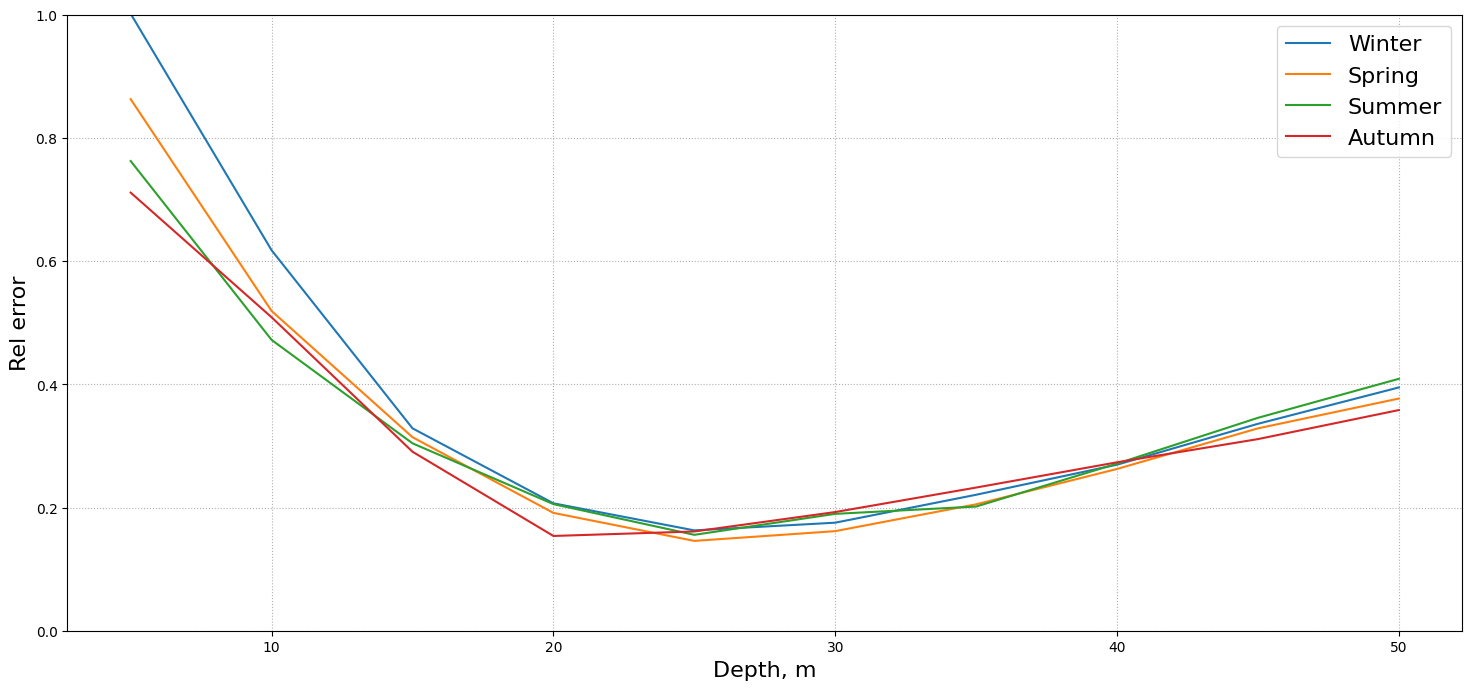

In [25]:
plt.figure(figsize=(18, 8))
plt.grid(ls=':')
for track in zs_all.keys():
    plt.plot(np.linspace(5, 50, 10), rel_by_z[track], label=seasons[track[:2]])
plt.xlabel('Depth, m', fontsize=16)
plt.ylabel('Rel error', fontsize=16)
plt.ylim((0, 1))
plt.legend(fontsize=16)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

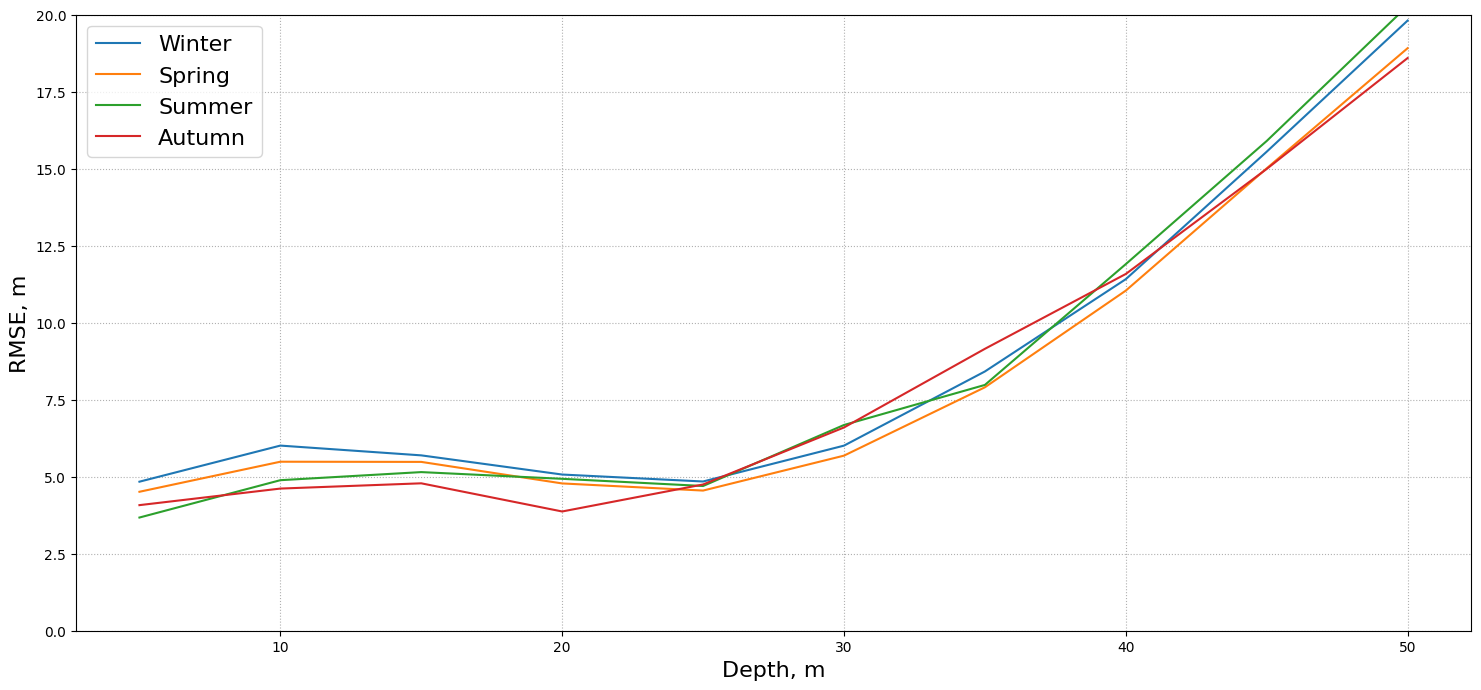

In [26]:
plt.figure(figsize=(18, 8))
plt.grid(ls=':')
for track in zs_all.keys():
    plt.plot(np.linspace(5, 50, 10), rmse_by_z[track], label=seasons[track[:2]])
plt.xlabel('Depth, m', fontsize=16)
plt.ylabel('RMSE, m', fontsize=16)
plt.ylim((0, 20))
plt.legend(fontsize=16)
plt.show

In [27]:
rmses_old = np.array(rmses_old)
rmses_old = rmses_old[rmses_old == rmses_old]
rels_old = np.array(rels_old)
rels_old = rels_old[rels_old == rels_old]

In [28]:
print('RMSE of old model:', np.mean(rmses_old))
print('RMSE of new model:', np.mean(rmses_new))
print('Rel error of old model:', np.mean(rels_old))
print('Rel error of new model:', np.mean(rels_new))

RMSE of old model: 8.483123184323903
RMSE of new model: 6.818050657768688
Rel error of old model: 0.48379584424339916
Rel error of new model: 0.33215713004817177


#### Визуализация

In [29]:
from typing import Tuple

def project_points_to_camera(
    points: np.ndarray, proj_matrix: np.ndarray, cam_res: Tuple[int, int]
) -> Tuple[np.ndarray, np.ndarray]:
    if points.shape[0] == 3:
        points = np.vstack((points, np.ones((1, points.shape[1]))))
    if len(points.shape) != 2 or points.shape[0] != 4:
        raise ValueError(
            f"Wrong shape of points array: {points.shape}; expected: (4, n), where n - number of points."
        )
    if proj_matrix.shape != (3, 4):
        raise ValueError(f"Wrong proj_matrix shape: {proj_matrix}; expected: (3, 4).")
    in_image = points[2, :] > 0
    depths = points[2, in_image]
    uvw = np.dot(proj_matrix, points[:, in_image])
    uv = uvw[:2, :]
    w = uvw[2, :]
    uv[0, :] /= w
    uv[1, :] /= w
    in_image = (uv[0, :] >= 0) * (uv[0, :] < cam_res[0]) * (uv[1, :] >= 0) * (uv[1, :] < cam_res[1])
    return uv[:, in_image].astype(int), depths[in_image]

In [30]:
def depths_to_colors(depths: np.ndarray, max_depth: int = 10, cmap: str = "hsv") -> np.ndarray:
    depths /= max_depth
    to_colormap = plt.get_cmap(cmap)
    rgba_values = to_colormap(depths, bytes=True)
    return rgba_values[:, :3].astype(int)

In [31]:
from cv2 import resize
%timeit resize(test_img, (480, 640))

659 μs ± 7.21 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
image_resized = resize(test_img, (640, 480))
image_resized.max()

255

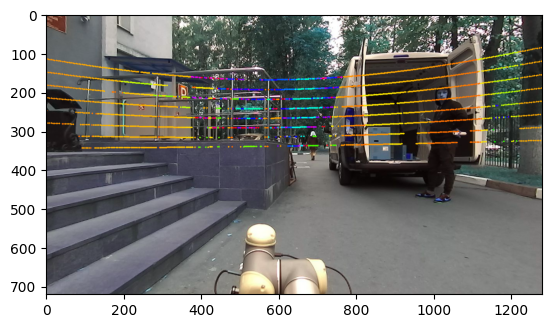

In [33]:
cloud_expanded = np.hstack([test_cloud, np.ones((test_cloud.shape[0], 1))])
b = tf_matrix.T @ cloud_expanded.T
b = b.T[b.T[:, 1] < 0].T
uv, depths = project_points_to_camera(b, proj_matrix, (1280, 720))
rgb_distances = depths_to_colors(depths, max_depth=50)
for point, d in zip(uv.T, rgb_distances):
    c = (int(d[0]), int(d[1]), int(d[2]))
    cv2.circle(test_img, point, radius=2, color=c, thickness=cv2.FILLED)
plt.imshow(test_img)

In [34]:
depth, zs, errors, rel_errors = de_old.get_depth_with_lidar(test_img, test_cloud)

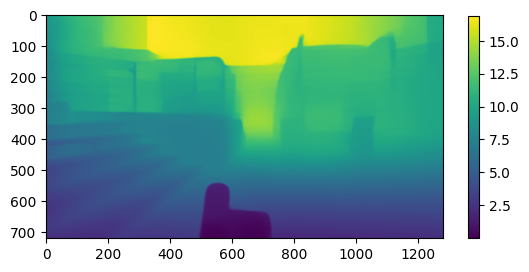

In [35]:
plt.imshow(depth)
plt.colorbar(shrink=0.6)

#### Создание облака точек по восстановленной глубине методом обратной проекции

In [36]:
camera_matrix

{'f': 683.6, 'cx': 615.1, 'cy': 345.3}

In [37]:
h, w = depth.shape
def get_point_cloud_from_depth(depth, f, cx, cy):
    i = np.tile(np.arange(h), w).reshape((w, h)).T
    j = np.tile(np.arange(w), h).reshape((h, w))
    z = depth.ravel()
    x = (j.ravel() - cx) / f * z
    y = (i.ravel() - cy) / f * z
    pcd = np.zeros((x.shape[0], 3))
    pcd[:, 0] = x# * norm_coef
    pcd[:, 1] = y# * norm_coef
    pcd[:, 2] = z# * norm_coef
    return pcd

pcd = get_point_cloud_from_depth(depth, camera_matrix['f'], camera_matrix['cx'], camera_matrix['cy'])

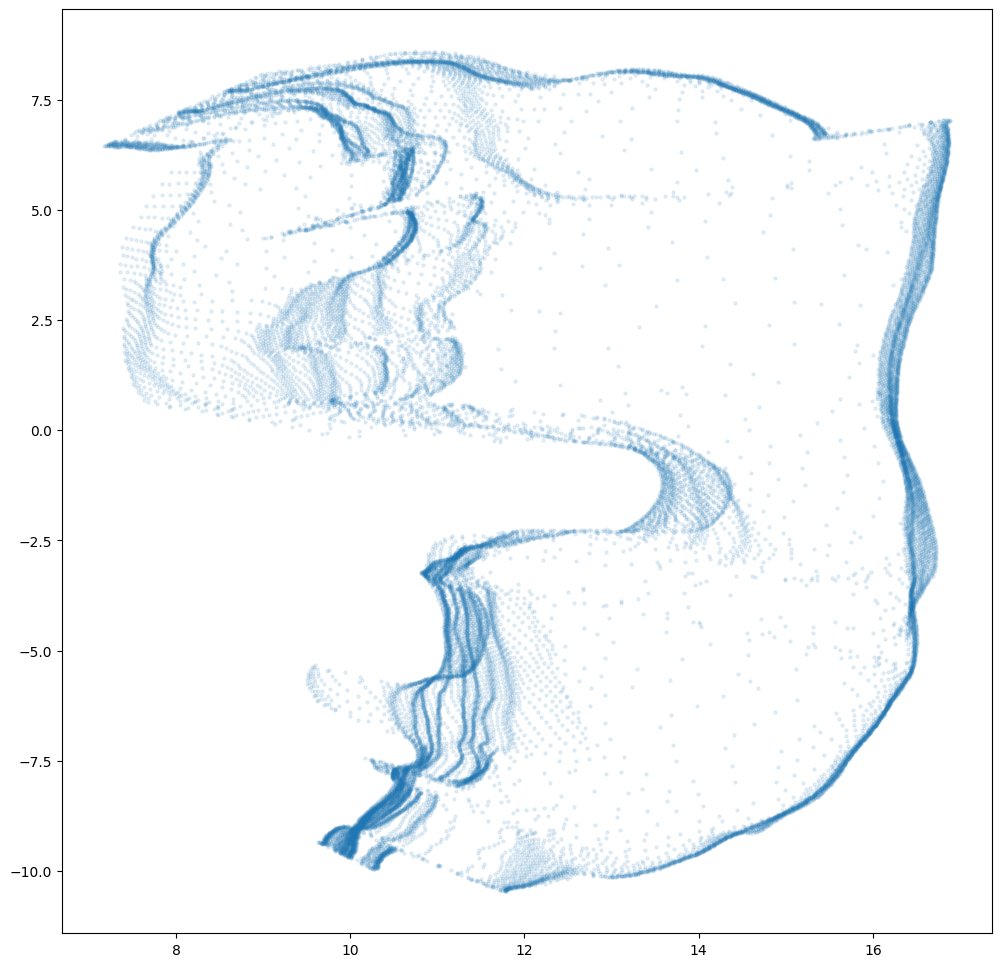

In [38]:
plt.figure(figsize=(12, 12))
plt.scatter(pcd[::17, 2][pcd[::17, 1] < 0.], -pcd[::17, 0][pcd[::17, 1] < 0.], s=5, alpha=0.1)
plt.show()

#### Сравнение восстановленного и лидарного облака

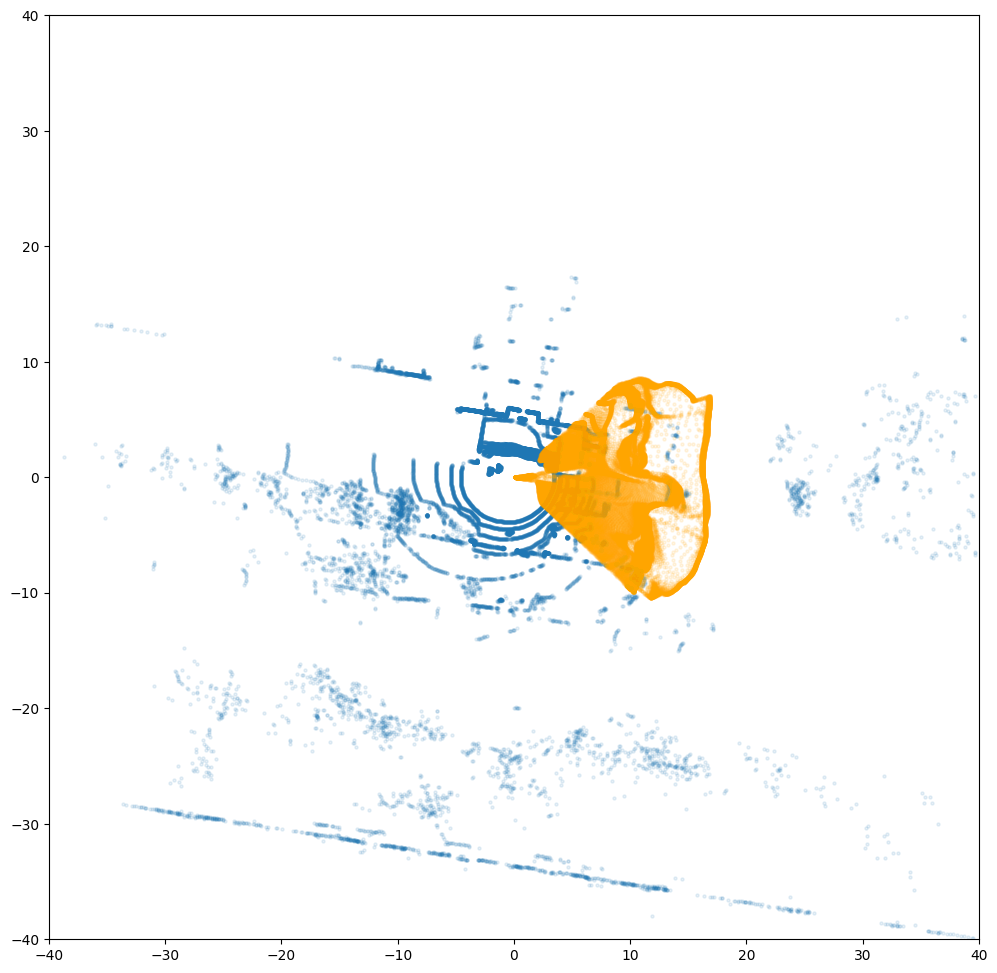

In [39]:
plt.figure(figsize=(12, 12))
plt.xlim((-40, 40))
plt.ylim((-40, 40))
plt.scatter(test_cloud[:, 0], test_cloud[:, 1], s=5, alpha=0.1)
#plt.scatter(test_cloud[:, 0][test_cloud[:, 2] > 0], test_cloud[:, 1][test_cloud[:, 2] > 0], s=5, alpha=0.1)
plt.scatter(pcd[::17, 2], -pcd[::17, 0], color='orange', s=5, alpha=0.1)
plt.show()